In [37]:
import pandas as pd
import numpy as np
import math
import os
import sys
import datetime

from sklearn.preprocessing import StandardScaler, FunctionTransformer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as dates
plt.style.use('seaborn-whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots
from sklearn.decomposition import PCA

C:\Users\user\AppData\Local\Temp\ipykernel_7156\1503949100.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [ ]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/MSIS Coursework/OddSem2023MAHE'
    DATA_DIR = DIR + '/Data/'
    os.chdir(DIR)
else:
    DATA_DIR = 'Data/'

In [3]:
## Read data
FILE = 'timeseriesdata.csv'
df = pd.read_csv(FILE, sep = ",", header = 0)
df['time'] = pd.to_datetime(df['time'], format='%m-%d-%Y %H.%M')
df.loc[:, (df.columns != 'time')] = df.loc[:, df.columns != 'time'].apply(pd.to_numeric, errors = 'coerce')
df = df.set_index('time')
df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_7156\502638629.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, (df.columns != 'time')] = df.loc[:, df.columns != 'time'].apply(pd.to_numeric, errors = 'coerce')


Cyclone_Inlet_Gas_Temp  Cyclone_Material_Temp  \
time                                                                 
2017-01-01 00:00:00                  867.63                 910.42   
2017-01-01 00:05:00                  879.23                 918.14   
2017-01-01 00:10:00                  875.67                 924.18   
2017-01-01 00:15:00                  875.28                 923.15   
2017-01-01 00:20:00                  891.66                 934.26   

                     Cyclone_Outlet_Gas_draft  Cyclone_cone_draft  \
time                                                                
2017-01-01 00:00:00                   -189.54             -186.04   
2017-01-01 00:05:00                   -184.33             -182.10   
2017-01-01 00:10:00                   -181.26             -166.47   
2017-01-01 00:15:00                   -179.15             -174.83   
2017-01-01 00:20:00                   -178.32             -173.72   

                     Cyclone_Gas_Outlet_Temp  Cyclone_Inlet_Draft  
time                                                               
2017-01-01 00:00:00                   852.13              -145.90  
2017-01-01 00:05:00                   862.53              -149.76  
2017-01-01 00:10:00                   866.06              -145.01  
2017-01-01 00:15:00                   865.85              -142.82  
2017-01-01 00:20:00                   876.06              -143.39

Text(0, 0.5, '% Missing Values')

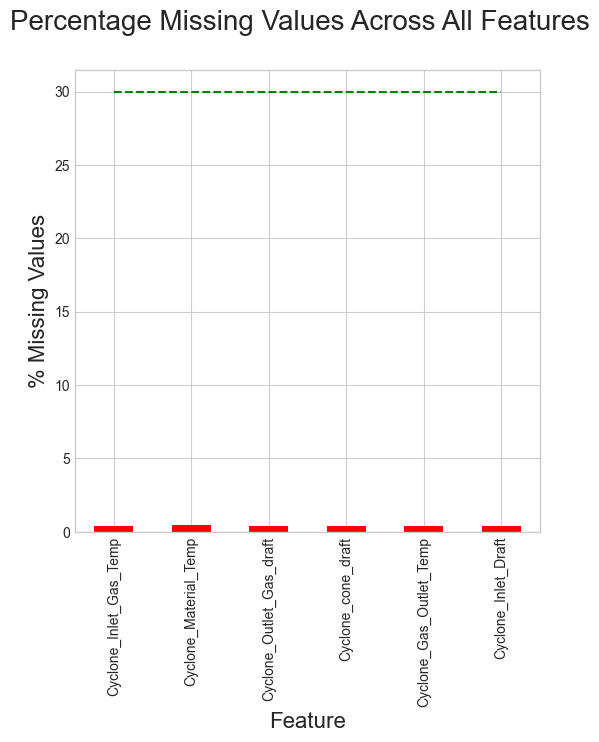

In [4]:
## Plot percentage of missing values (NaNs) for each feature
cutoff = 30
fig = plt.figure(figsize=(6, 6))
percent_missing = (df.isna().sum() / df.shape[0]) * 100
percent_missing.plot(kind = 'bar', color = cm.rainbow(np.linspace(0, 1, 2))[(percent_missing <= cutoff).values.astype(int)])
plt.plot(np.arange(df.shape[1]), np.repeat(cutoff, df.shape[1]), 'g--')
fig.suptitle('Percentage Missing Values Across All Features', fontsize = 20)
plt.xlabel('Feature', fontsize = 16)
plt.ylabel('% Missing Values', fontsize = 16)

In [5]:
## Linear interpolation for one column
#df['Cyclone_Inlet_Gas_Temp'] = df['Cyclone_Inlet_Gas_Temp'].interpolate(method = 'linear')
df.loc[:, (df.columns != 'time')] = df.loc[:, df.columns != 'time'].interpolate(method = 'linear')
(df.isna().sum() / df.shape[0]) * 100

Cyclone_Inlet_Gas_Temp      0.0
Cyclone_Material_Temp       0.0
Cyclone_Outlet_Gas_draft    0.0
Cyclone_cone_draft          0.0
Cyclone_Gas_Outlet_Temp     0.0
Cyclone_Inlet_Draft         0.0
dtype: float64

In [6]:
## Data preparation for anomaly detection using numpy
feature = 'Cyclone_Inlet_Gas_Temp'
# Note that 5min is the sampling period in the dataset which we specify and convert to seconds
sampling_period = int(pd.Timedelta('5min').total_seconds())
# We are interested in 30min data for each sample which we specify and convert to seconds
time_period = int(pd.Timedelta('30min').total_seconds())
# The following is a dictionary that we will use for transforming the columns
# 'identity' corresponds to no transformation, 'standard' means standardizing
scaler = {'identity': FunctionTransformer(lambda x: x), 'standard': StandardScaler()}
df_transformed = pd.DataFrame(scaler['standard'].fit_transform(df))
df_transformed.columns = df.columns.copy()
df_transformed.index = df.index.copy()
ncols_reshape = int(pd.Timedelta(str(time_period/sampling_period)+'S').total_seconds())
nrows_reshape = df_transformed.shape[0]//ncols_reshape
df_samples = pd.DataFrame(np.array(df_transformed[feature])[0:nrows_reshape*ncols_reshape].reshape(nrows_reshape, ncols_reshape))
df_samples.index = pd.date_range(df_transformed.index.min(),
                                 df_transformed.index.max() + pd.DateOffset(days = 1),
                                 normalize = True,
                                 freq = str(time_period)+'S')[0:df_samples.shape[0]]
df_samples.head()

0         1         2         3         4  \
2017-01-01 00:00:00  0.429433  0.464612  0.453816  0.452633  0.502307   
2017-01-01 00:30:00  0.545613  0.460366  0.439684  0.544157  0.452117   
2017-01-01 01:00:00  0.450298  0.474316  0.436924  0.522959  0.408417   
2017-01-01 01:30:00  0.412936  0.440836  0.502550  0.430555  0.428827   
2017-01-01 02:00:00  0.468827  0.495363  0.438895  0.441139  0.447265   

                            5  
2017-01-01 00:00:00  0.462519  
2017-01-01 00:30:00  0.531238  
2017-01-01 01:00:00  0.499820  
2017-01-01 01:30:00  0.433861  
2017-01-01 02:00:00  0.455574

In [7]:
## Data preparation for anomaly detection using numpy (all features are considered)
# Note that 5min is the sampling period in the dataset which we specify and convert to seconds
sampling_period = int(pd.Timedelta('5min').total_seconds())
# We are interested in 30min data for each sample which we specify and convert to seconds
time_period = int(pd.Timedelta('30min').total_seconds())
# The following is a dictionary that we will use for transforming the columns
# 'identity' corresponds to no transformation, 'standard' means standardizing
scaler = {'identity': FunctionTransformer(lambda x: x), 'standard': StandardScaler()}
df_transformed = pd.DataFrame(scaler['standard'].fit_transform(df))
df_transformed.columns = df.columns.copy()
df_transformed.index = df.index.copy()
ncols_reshape = int(pd.Timedelta(str(time_period/sampling_period)+'S').total_seconds())
nrows_reshape = df_transformed.shape[0]//ncols_reshape
df_samples = pd.DataFrame(np.concatenate([np.array(df_transformed[feature])[0:nrows_reshape*ncols_reshape].reshape(nrows_reshape, ncols_reshape) for feature in df_transformed.columns.values], axis = 1))
df_samples.index = pd.date_range(df_transformed.index.min(),
                                 df_transformed.index.max() + pd.DateOffset(days = 1),
                                 normalize = True,
                                 freq = str(time_period)+'S')[0:df_samples.shape[0]]
df_samples.head()

0         1         2         3         4   \
2017-01-01 00:00:00  0.429433  0.464612  0.453816  0.452633  0.502307   
2017-01-01 00:30:00  0.545613  0.460366  0.439684  0.544157  0.452117   
2017-01-01 01:00:00  0.450298  0.474316  0.436924  0.522959  0.408417   
2017-01-01 01:30:00  0.412936  0.440836  0.502550  0.430555  0.428827   
2017-01-01 02:00:00  0.468827  0.495363  0.438895  0.441139  0.447265   

                           5         6         7         8         9   ...  \
2017-01-01 00:00:00  0.462519  0.457338  0.479265  0.496420  0.493495  ...   
2017-01-01 00:30:00  0.531238  0.573506  0.540303  0.537747  0.538684  ...   
2017-01-01 01:00:00  0.499820  0.506731  0.536156  0.499687  0.553567  ...   
2017-01-01 01:30:00  0.433861  0.491450  0.482077  0.520790  0.491052  ...   
2017-01-01 02:00:00  0.455574  0.518149  0.541553  0.536810  0.514258  ...   

                           26        27        28        29        30  \
2017-01-01 00:00:00  0.464489  0.463846  0.495128  0.477510 -0.062775   
2017-01-01 00:30:00  0.480697  0.480697  0.502940  0.508762 -0.139009   
2017-01-01 01:00:00  0.459005  0.510539  0.448281  0.490103 -0.109955   
2017-01-01 01:30:00  0.496966  0.471505  0.464489  0.460598 -0.037449   
2017-01-01 02:00:00  0.498559  0.488908  0.495587  0.484128  0.062955   

                           31        32        33        34        35  
2017-01-01 00:00:00 -0.112398 -0.051333 -0.023179 -0.030507 -0.075887  
2017-01-01 00:30:00 -0.111626 -0.059175 -0.101085 -0.040920 -0.010580  
2017-01-01 01:00:00 -0.031149 -0.072802  0.006004  0.021688 -0.117540  
2017-01-01 01:30:00 -0.065603 -0.039763 -0.038092 -0.023436  0.008832  
2017-01-01 02:00:00  0.028758 -0.078330 -0.002481 -0.052490 -0.056475  

[5 rows x 36 columns]

In [38]:
samples = df_samples.to_numpy()
sc = StandardScaler()
scaled = sc.fit_transform(samples)
X = scaled.reshape(62953,6,6)
X[0:5][:][:]

array([[[ 0.42973823,  0.46410301,  0.45393581,  0.45247171,
          0.5021905 ,  0.46288091],
        [ 0.45805033,  0.47856298,  0.49706413,  0.49277102,
          0.52517505,  0.51966522],
        [-0.12133019, -0.06857102, -0.03814229, -0.01708214,
         -0.00925667, -0.11049588],
        [-0.24122828, -0.19684568, -0.0244272 , -0.11721432,
         -0.10528007, -0.15271943],
        [ 0.42207247,  0.45357597,  0.46436559,  0.46388076,
          0.49502198,  0.47754127],
        [-0.06243032, -0.11166824, -0.05124166, -0.02314995,
         -0.03113834, -0.07642978]],

       [[ 0.54592563,  0.45985816,  0.43980213,  0.54399275,
          0.45200217,  0.5316056 ],
        [ 0.57422783,  0.53958025,  0.53837281,  0.53798636,
          0.54966132,  0.55036902],
        [-0.06760198, -0.06726342, -0.06771007, -0.052099  ,
          0.00604324, -0.03891969],
        [-0.20390226, -0.18654984, -0.18707371, -0.15486897,
         -0.04624383, -0.09490479],
        [ 0.53623832,  0.494

In [59]:
len(X[1])

6

In [61]:
pcas = []
explained_variances = []
for i in range(5):
    pca = PCA(n_components = 1)
    pca.fit(X[i][:][:])

    pcas.append(pca.components_)

    explained_variances.append(pca.explained_variance_)
print(pcas)
print(explained_variances)

[array([[-0.42420508, -0.43113235, -0.36698978, -0.38136643, -0.40500068,
        -0.43592149]]), array([[-0.46336576, -0.41755736, -0.39947691, -0.41858546, -0.35478972,
        -0.38764248]]), array([[-0.43854793, -0.38930667, -0.41452689, -0.40288312, -0.32545011,
        -0.46481276]]), array([[-0.39526807, -0.42288371, -0.45361057, -0.42702875, -0.37872836,
        -0.36521398]]), array([[0.34886048, 0.42723849, 0.4319768 , 0.39035525, 0.43958065,
        0.40441477]])]
[array([0.57178073]), array([0.67134166]), array([0.5424079]), array([0.46843112]), array([0.44098048])]


In [62]:
cev = np.cumsum(explained_variances)
for i in cev:
    print((i/2.69494189)*100)

21.216811167180285
46.12798507266871
66.25487192190201
83.63673524611873
99.99999996158091


In [65]:
pcas = []
explained_variances = []
for i in range(len(X)):
    pca = PCA(n_components = 1)
    pca.fit(X[i][:][:])

    pcas.append(pca.components_)

    explained_variances.append(pca.explained_variance_)
print(pcas)
print(explained_variances)

[array([[-0.42420508, -0.43113235, -0.36698978, -0.38136643, -0.40500068,
        -0.43592149]]), array([[-0.46336576, -0.41755736, -0.39947691, -0.41858546, -0.35478972,
        -0.38764248]]), array([[-0.43854793, -0.38930667, -0.41452689, -0.40288312, -0.32545011,
        -0.46481276]]), array([[-0.39526807, -0.42288371, -0.45361057, -0.42702875, -0.37872836,
        -0.36521398]]), array([[0.34886048, 0.42723849, 0.4319768 , 0.39035525, 0.43958065,
        0.40441477]]), array([[0.43208107, 0.41327408, 0.43480028, 0.33542199, 0.41629875,
        0.40944675]]), array([[0.3190664 , 0.47743729, 0.41609391, 0.36597809, 0.3913722 ,
        0.45826189]]), array([[0.50042443, 0.32987254, 0.42464494, 0.34480164, 0.4084473 ,
        0.41799378]]), array([[0.37484369, 0.39302208, 0.40488187, 0.46644229, 0.3979535 ,
        0.4064002 ]]), array([[-0.42862201, -0.4212652 , -0.41431504, -0.37573095, -0.3925029 ,
        -0.41464392]]), array([[-0.39956464, -0.44046715, -0.41223096, -0.32096653,

In [66]:
np.cumsum(explained_variances)

array([5.71780732e-01, 1.24312239e+00, 1.78553030e+00, ...,
       4.31961417e+05, 4.31963250e+05, 4.31965010e+05])

In [69]:
cev = np.cumsum(explained_variances)
values = []
for i in cev:
    values.append((i/4.31965010e+05)*100)
values[10000]

6.964736463422929

In [8]:
## Data preparation for anomaly detection using pandas groupby()
feature = 'Cyclone_Inlet_Gas_Temp'
# Note that 5min is the sampling period in the dataset which we specify and convert to seconds
sampling_period = int(pd.Timedelta('5min').total_seconds())
# We are interested in 30min data for each sample which we specify and convert to seconds
time_period = int(pd.Timedelta('30min').total_seconds())
# The following is a dictionary that we will use for transforming the columns
# 'identity' corresponds to no transformation, 'standard' means standardizing
scaler = {'identity': FunctionTransformer(lambda x: x), 'standard': StandardScaler()}
df_transformed = pd.DataFrame(scaler['standard'].fit_transform(df))
df_transformed.columns = df.columns.copy()
df_transformed.index = df.index.copy()
df_samples = df_transformed.groupby(pd.Grouper(freq = str(time_period)+'S')).apply(lambda x: x[feature].values if len(x[feature].values) == int(pd.Timedelta(str(time_period/sampling_period)+'S').total_seconds()) else np.nan)
df_samples = df_samples.dropna()
df_samples = pd.DataFrame(df_samples.values.tolist(), index = df_samples.index)
df_samples.head()

0         1         2         3         4  \
time                                                                    
2017-01-01 00:00:00  0.429433  0.464612  0.453816  0.452633  0.502307   
2017-01-01 00:30:00  0.545613  0.460366  0.439684  0.544157  0.452117   
2017-01-01 01:00:00  0.450298  0.474316  0.436924  0.522959  0.408417   
2017-01-01 01:30:00  0.412936  0.440836  0.502550  0.430555  0.428827   
2017-01-01 02:00:00  0.468827  0.495363  0.438895  0.441139  0.447265   

                            5  
time                           
2017-01-01 00:00:00  0.462519  
2017-01-01 00:30:00  0.531238  
2017-01-01 01:00:00  0.499820  
2017-01-01 01:30:00  0.433861  
2017-01-01 02:00:00  0.455574